<a href="https://colab.research.google.com/github/jp2011/kalman-filters-examples/blob/main/kalman_filters_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Kalman Filter

This is a detailed derivation of the filtering updates for the Kalman filter. The details follow closely the **Bayesian Filtering and Smoothing** book by *Simo Särkkä*.


Note that all letters in the text refer to vectors or matrices rather than scalars, hence no boldface in the notation below.


## Preliminaries

Before we proceed, we go through the derivation of some crucial properties of matrices and Gaussian random variables.




### Inversion of a partitioned matrix

Let $K$ be a invertible matrix partitioned as 
\begin{equation}
K = \begin{pmatrix}
    A & B\\
    C & D
    \end{pmatrix}.
\end{equation}
Its inverse is the given by
\begin{equation}
    \begin{pmatrix}
    A & B\\
    C & D
    \end{pmatrix}^{-1}
    = 
    \begin{pmatrix}
    M         & - M B D^{-1}\\
    -D^{-1}CM & D^{-1} + D^{-1} C M B D^{-1}
    \end{pmatrix},
\end{equation}
where $M = (A - BD^{-1}C)^{-1}$.

### Joint distribution of a conditioned Gaussian on another Gaussian.

To derive the Kalman filter, we require several properties of Gaussian random variables.

Let $x$ and $y$ be random variables with Gaussian distributions:
\begin{align} 
x        & \sim \mathcal{N}(m, P), \\
y \mid x & \sim \mathcal{N}(Hx + u, R).
\end{align}
The joint distribution of $x$ and $y$ is given as
\begin{equation}
\left(\begin{array}{l}
x \\
y
\end{array}\right) \sim \mathcal{N}\left(\left(\begin{array}{c}
m \\
H m+u
\end{array}\right),\left(\begin{array}{cc}
P & P H^{\top} \\
H P & H P H^{\top}+R
\end{array}\right)\right)
\end{equation}
#### Proof
Let $p(x,y)$ be the joint density.
\begin{align}
\log p(x, y) & = \log p(y \mid x) + \log p(x) \\
             & = -\frac{1}{2}(y - Hx - u)^\top R^{-1}(y - Hx - u)
                 -\frac{1}{2}(x - m)^\top P^{-1} (x - m) + \text{const}
\end{align}
This is a quadratic function of $x$ and $y$ so the joint distribution must be Gaussian. Considering the second-order terms we obtain:
\begin{align}
& - \frac{1}{2} y^\top R^{-1} y - \frac{1}{2}x^{\top}\big(H^\top R^{-1} H + P^{-1}\big)x + \frac{1}{2} y^\top R^{-1} H x + \frac{1}{2} x^\top H^\top R^{-1} y \\
& = -\frac{1}{2} \begin{pmatrix} x \\ y \end{pmatrix} ^ \top 
     \begin{pmatrix}
         H^\top R^{-1} H + P^{-1}      & - H^\top R^{-1} \\
         -R^{-1}H                      & R^{-1}
     \end{pmatrix}
     \begin{pmatrix} x \\ y \end{pmatrix},
\end{align}
from where the covariance matrix given by
\begin{equation}
     \begin{pmatrix}
         H^\top R^{-1} H + P^{-1}      & - H^\top R^{-1} \\
         -R^{-1}H                      & R^{-1}
     \end{pmatrix} ^ {-1}
     = \begin{pmatrix}
           P        & P H^\top \\
           H^\top P & R + H P H^\top
       \end{pmatrix}.
\end{equation}
In the last step we used the lemma for inverting a partitioned matrix.


### Conditional distribution from a joint multivariate Gaussian



## Linear Gaussian Model

We have a time-evolving state process $x_k$ of which we observe a noisy version $y_k$ at time $k$. By assuming linear state transitions and Gaussian noise for both the process and the measurements the model is defined as follows:
\begin{align}
x_k & = A_{k-1} x_{k-1} + q_{k-1}, \\
y_K & = H_k x_k + r_k,
\end{align}
where $A_{k}$, $H_k$, $Q_k$, and $R_k$ are given and 
\begin{align}
q_{k-1} & \sim \mathcal{N}(0, Q_{k-1}), \\
r_{k}   & \sim \mathcal{N}(0, R_k),
\end{align}
are the process and measurement noise, respectively. Operator $A_{k}$ is the linear transition operator (matrix), $H_k$ is the observation operator, $Q_k$ is the covariance matrix of the state transition noise, $R_k$ is the measurement noise. We assume that initially we have:
\begin{align}
x_0 & \sim \mathcal{N}(m_0, P_0).
\end{align}

Due to the linearity and Gaussianity, we have
\begin{align}
p(x_k \mid x_{k-1}) & = \mathcal{N}(x_k \mid A_{k-1}x_{k-1}, Q_{k-1}) \\
p(y_k \mid x_k)     & = \mathcal{N}(y_k \mid H_k x_k, R_k) 
\end{align}

Our goal is to assimilate the date as they arrive in time and derive a distribution. In other words we seek to infer:
1. $p(x_k \mid y_{1:k-1})$: **prediction step**
2. $p(x_k \mid y_{1:k})$: **update step**


### Prediction Step

We are interested in deriving $p(x_k \mid y_{1:k-1})$. Using the Markov property we have
\begin{align}
p(x_k, x_{k-1} \mid y_{1:k-1}) 
    & = p(x_k \mid x_{k-1}, y_{1:k-1}) p(x_{k-1} \mid y_{1:k-1}) \\
    & = p(x_k \mid x_{k-1}) p(x_{k-1} \mid y_{1:k-1}).                      
\end{align}
The first term is Gaussian as we have assumed that above. We derive the second term.

Thanks to Bayes's theorem we have
\begin{align}
p(x_{k-1} \mid y_{k-1}) & \propto p(y_{k-1} \mid x_{k-1}) p(x_{k-1}).
\end{align}
Both of the terms on RHS of above are Gaussian so the resulting distribution is Gaussian with mean $m_{k-1}$ and covariance matrix $P_{k-1}$, so we have
\begin{align}
  x_{k-1} \mid y_{k-1} & \sim \mathcal{N}(m_{k-1}, P_{k-1})
\end{align}

From that we have 
\begin{align}
p(x_k, x_{k-1} \mid y_{1:k-1})  
   & = \mathcal{N}(x_k \mid A_{k-1} x_{k-1}, Q_{k-1}) 
       \mathcal{N}(x_{k-1} \mid m_{k-1}, P_{k-1}) \\
   & = \mathcal{N} \Bigg( 
        \bigg(\begin{array}{l}
        x_{k-1} \\
        x_{k}
        \end{array} \bigg)
        \bigg| 
        \bigg( \begin{array}{l}
        m_{k-1} \\
        A_{k-1} m_{k-1}
        \end{array}\bigg),
        \begin{pmatrix}
          P_{k-1}          & P_{k-1} A_{k-1}^\top\\
          A_{k-1} P_{k-1}  & Q_{k-1} + A_{k-1} P_{k-1} A_{k-1}^\top
        \end{pmatrix}
      \Bigg)
\end{align}

Now, marginalising $p(x_k, x_{k-1} \mid y_{1:k-1})$ over $x_{k-1}$, we obtain
\begin{align}
p(x_k \mid y_{1:k-1}) 
  = \mathcal{N}(x_k \mid A_{k-1}m_{k-1}, Q_{k-1} + A P_{k-1} A^\top) 
  =: \mathcal{N}(\bar{m}, \bar{P}_k)
\end{align}

### Update Step

We proceed by deriving $p(x_k, y_k \mid y_{1:k-1})$ and subsequently conditioning on $y_k$ itself, giving $p(x_k \mid y_k, y_{1:k-1}$ which is the desired distribution.

\begin{align}
p(x_k, y_k \mid y_{1:k-1}) 
  & = p(y_k \mid x_k, y_{1:k-1}) p(x_k \mid y_{1:k-1}) \\
  & = p(y_k \mid x_k) p(x_k \mid y_{1:k-1}) & (\text{Markov property}) \\
  & = \mathcal{N}(y_k \mid H_k x_k, R_k) 
      \mathcal{N}(x_k \mid A_{k-1}m_{k-1}, Q_{k-1} + A P_{k-1} A^\top) \\
  & = \mathcal{N} \Bigg(  
    \bigg(\begin{array}{l}
        x_{k} \\
        y_{k}
        \end{array} \bigg)
        \bigg| 
        \bigg( \begin{array}{l}
        A_{k-1} m_{k-1} \\
        H_k A_{k-1} m_{k-1}
        \end{array}\bigg),
        \begin{pmatrix}
          \bar{P}_k          & \bar{P}_{k} H_{k}^\top\\
          H_{k} \bar{P}_{k}  & R_{k} + H_k \bar{P}_{k} H_k^\top
        \end{pmatrix}\Bigg)
\end{align}

Now conditioning on $y_k$ as shown in the Preliminaries section, we have
\begin{align}
p(x_k \mid y_k, y_{1:k-1}) 
  & = \mathcal{N}\big(x_k \mid 
    A_{k-1}m_{k-1} + (R_{k} + H_k \bar{P}_{k} H_k^\top)
         (y_k - H_k A_{k-1}m_{k-1}),
    \bar{P}_k 
        - \bar{P}_k H_k^\top (R_{k} + H_k \bar{P}_{k} H_k^\top) H_k \bar{P}_k
\big)
\end{align}


# Extended Kalman Filter (chatGPT)


In this code, F(x) and H(x) are non-linear functions representing the state transition and observation models respectively. dF_dx(x) and dH_dx(x) are the Jacobian matrices of the respective functions and represent the linearized state transition and observation matrices.

The predict() method takes in the current state estimate x, the state estimate covariance P, the non-linear state transition function F(x), the process noise covariance matrix Q, and the linearized state transition matrix dF_dx(x). It uses the linearized state transition matrix and the non-linear state transition function to predict the next state estimate and the predicted state estimate covariance.

The update() method takes in the predicted state estimate, predicted state estimate covariance, the observation z, the non-linear observation function H(x), the observation noise covariance matrix R and the linearized observation matrix dH_dx(x). It uses the linearized observation matrix and the non-linear observation function to update the state estimate and the updated state estimate covariance.

It's important to note that this is a skeleton code and one should use the exact mathematical model of the system to calculate the specific Jacobian matrix and the non-linear function representing the state transition and observation model. Also, the choice of the appropriate linearization method (e.g. Jacobian) depends on the specific use case and the nature of the non-linearities present in the system.

In [1]:
# Code generated by ChatGPT

import numpy as np

class ExtendedKalmanFilter:
    def __init__(self, state_dim, obs_dim):
        self.state_dim = state_dim
        self.obs_dim = obs_dim

    def predict(self, x, P, F, Q, dF_dx):
        # Non-linear state transition
        x = F(x)
        # Linearized state transition matrix
        F = dF_dx(x)
        P = np.dot(F, np.dot(P, F.T)) + Q
        return x, P

    def update(self, x, P, z, H, R, dH_dx):
        # Linearized observation matrix
        H = dH_dx(x)
        # Innovation
        y = z - H(x)
        S = np.dot(H, np.dot(P, H.T)) + R
        K = np.dot(P, np.dot(H.T, np.linalg.inv(S)))
        x = x + np.dot(K, y)
        P = P - np.dot(K, np.dot(H, P))
        return x, P

In [4]:
ekf = ExtendedKalmanFilter(2, 1)

# Unscented Kalman Filter (chatGPT)

The Unscented Kalman Filter (UKF) is another method for estimating the state of non-linear systems. Like the Extended Kalman Filter (EKF), it can handle non-linear models, but it does so in a different way.

The EKF linearizes the non-linear models around the current estimate of the state, and then uses the linearized models to perform the prediction and update steps of the Kalman filter algorithm. However, this linearization process can introduce errors, especially if the non-linearity is large or the system is highly non-linear.

The UKF, on the other hand, avoids linearization by directly propagating the probability density function (PDF) of the system state. It does this by selecting a set of "sigma points" that represent the PDF, and then propagating these points through the non-linear system dynamics and measurements. The mean and covariance of the propagated sigma points are then used to estimate the state and error covariance.

Here's some sample Python code for an Unscented Kalman Filter:

In [5]:
import numpy as np

class UnscentedKalmanFilter:
    def __init__(self, state_dim, obs_dim, alpha, kappa, beta):
        self.state_dim = state_dim
        self.obs_dim = obs_dim
        self.alpha = alpha
        self.kappa = kappa
        self.beta = beta
        self.lambda_ = self.alpha**2 * (self.state_dim + self.kappa) - self.state_dim

    def predict(self, x, P, f, Q):
        # Compute sigma points
        sigma_points = self.compute_sigma_points(x, P)
        # Propagate sigma points through the dynamics function
        sigma_points_pred = np.apply_along_axis(f, 1, sigma_points)
        # Compute predicted mean and covariance
        x_pred = np.mean(sigma_points_pred, axis=0)
        P_pred = self.compute_covariance(sigma_points_pred, x_pred, Q)
        return x_pred, P_pred

    def update(self, x, P, z, h, R):
        # Compute sigma points
        sigma_points = self.compute_sigma_points(x, P)
        # Propagate sigma points through the measurement function
        sigma_points_obs = np.apply_along_axis(h, 1, sigma_points)
        # Compute predicted mean and covariance
        z_pred = np.mean(sigma_points_obs, axis=0)
        P_zz = self.compute_covariance(sigma_points_obs, z_pred, R)
        P_xz = self.compute_cross_covariance(sigma_points, x, sigma_points_obs, z_pred)
        # Compute Kalman gain
        K = np.dot(P_xz, np.linalg.inv(P_zz))
        # Update estimate
        x = x + np.dot(K, z - z_pred)
        P = P - np.dot(K, np.dot(P_zz, K.T))

## Ensemble Kalman Filter

The code below is not GPT-generated :) 







In [ ]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt



class EnsembleKalmanFilter:

  def __init__(self, *, state_ensemble=None, transition_model=None):

    self.t = 0
    self.num_ensemble=state_ensemble.shape[0]
    self.d = state_ensemble.shape[1]

    self.state_ensemble = state_ensemble
    self.forecast_ensemble = np.zeros(self.state_ensemble.shape)
    self.transition_model = transition_model

  def get_mean(self):
    return np.mean(self.state_ensemble, axis=0)

  def get_cov(self):
     return np.cov(self.state_ensemble.T)

  def predict(self, model_error_cov_sqrt):
    
    for i in range(self.num_ensemble):
      self.forecast_ensemble[i, :] = self.transition_model(self.state_ensemble[i, :]) + model_error_cov_sqrt @ np.random.normal(size=self.d)
      self.t += 1

  def update(self, y, R_sqrt, H):

    µ_hat_k = np.mean(self.forecast_ensemble, axis=0)
    Σ_hat_k_sqrt = (1 / np.sqrt(self.num_ensemble - 1)) * (self.forecast_ensemble - µ_hat_k[np.newaxis, :]).T

    for i in range(self.num_ensemble):
      y_sample = H @ self.state_ensemble[i, :] + R_sqrt @ np.random.normal(size=y.shape[0])
      kalman_gain = Σ_hat_k_sqrt @ Σ_hat_k_sqrt.T @ H.T @ np.linalg.inv(H @ Σ_hat_k_sqrt @ Σ_hat_k_sqrt.T @ H.T + R_sqrt @ R_sqrt.T)
      self.state_ensemble[i, :] = self.forecast_ensemble[i, :] +  kalman_gain @ (y - y_sample) 

    
def sample_p0(num_samples):
  rv = multivariate_normal(mean=None, cov=[[1., 0.], [0., 1.]], allow_singular=False)
  return rv.rvs(size=num_samples)


def noisy_observations(noise_level=0.1):
  return np.asarray([2, 2]) + multivariate_normal.rvs(cov=noise_level, size=2)

def transition(state):
  return state


transition_cov = 1e-5 * np.asarray([[1, 0.95], [0.95, 1]])
filter_example = EnsembleKalmanFilter(state_ensemble=sample_p0(50), 
                                      transition_model=transition)

# generate noisy measurements and get noise cov
data, means, sds = [], [], []
for n in range(200):
  
  means.append(filter_example.get_mean())
  sds.append(np.diag(filter_example.get_cov()))
  filter_example.predict(np.linalg.cholesky(transition_cov))

  if n % 9 == 0:
    
    if n % 2 == 0:
    
      A_projection = np.asarray([[1., 0.]])
      y = np.asarray([noisy_observations()[0]])
      data.append([y, np.nan])
    else:
      A_projection = np.asarray([[0., 1.]])
      y = np.asarray([noisy_observations()[1]])
      data.append([np.nan, y])
    obs_cov_sqrt = np.asarray([[1.]])
    filter_example.update(y, obs_cov_sqrt, A_projection)
  else:
    data.append([np.nan, np.nan])

print(filter_example.get_mean())
print(filter_example.get_cov())

means = np.asarray(means)
sds = np.asarray(sds)
data = np.asarray(data)

[1.8045006  1.82992458]
[[ 0.12347225 -0.02441817]
 [-0.02441817  0.07541701]]


<ipython-input-1-b4d2d00c6a19>:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.asarray(data)


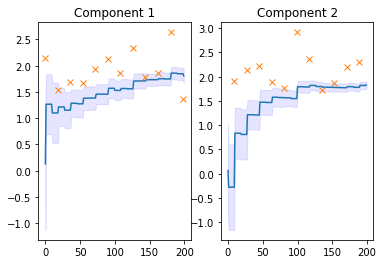

In [ ]:
fig, ax = plt.subplots(1, 2)

ax[0].plot(means[:, 0])
ax[0].plot(data[:, 0], marker='x')
ax[0].fill_between(range(sds.shape[0]), (means[:, 0] - sds[:, 0]), (means[:, 0] + sds[:, 0]), color='b', alpha=.1)
ax[0].set_title("Component 1")

ax[1].plot(means[:, 1])
ax[1].plot(data[:, 1], marker='x')
ax[1].fill_between(range(sds.shape[0]), (means[:, 1] - sds[:, 1]), (means[:, 1] + sds[:, 1]), color='b', alpha=.1)
ax[1].set_title("Component 2")

plt.show()